In [155]:
import mudata as md
import muon as mu
import scanpy as sc
import anndata as ad
import scipy.stats as stats
import decoupler as dc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import gseapy as gp
import re
import os

In [2]:
mu.set_options(pull_on_update = False)

In [3]:
#Load MuData Objects
day_14_data_combined = mu.read("D14_CITESeq_ALL.h5mu")
day_28_data_combined = mu.read("D28_CITESeq_ALL.h5mu")
D14_NK = mu.read("D14_CITESeq_NK.h5mu")
D28_NK = mu.read("D28_CITESeq_NK.h5mu")

In [23]:
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 12

## Figure 2

#### Figure 2A

Text(0, 0.5, '')

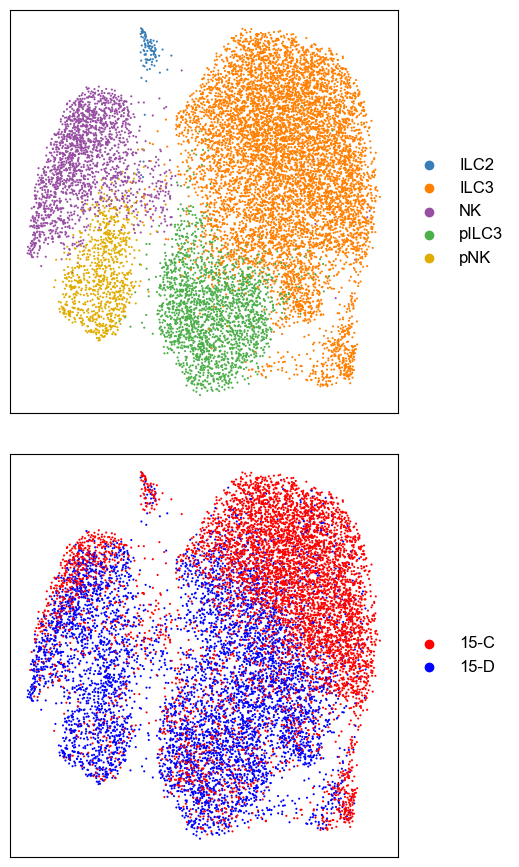

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 11), gridspec_kw={"hspace": 0.1})

ax1_dict = sc.pl.umap(
    day_28_data_combined.mod['rna'], color='celltype', ax=ax1, show=False, legend_fontsize=12, title='', palette=['#377eb8', '#ff7f00', '#984ea3', '#4daf4a', '#E1AC00']
)
ax1.set_xlabel('')  # Remove X-axis label
ax1.set_ylabel('')  # Remove Y-axis label

ax2_dict = sc.pl.umap(
    day_28_data_combined.mod['rna'], color='condition', ax=ax2, show=False, legend_fontsize=12, title='', palette=['red', 'blue']
)
ax2.set_xlabel('')  # Remove X-axis label
ax2.set_ylabel('')  # Remove Y-axis label

# Save the figure
#fig.savefig("figures/d28_umaps_plot.png", dpi=300, bbox_inches="tight")

#### Figure 2B

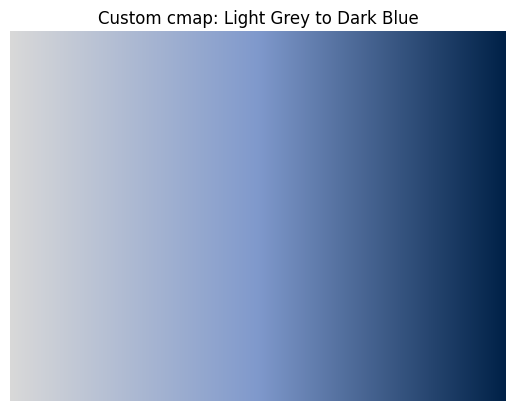

In [13]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = [(0.85, 0.85, 0.85), (0.5, 0.6, 0.8), (0.0, 0.13, 0.28)]

# Create the custom colormap
cmap_custom = LinearSegmentedColormap.from_list("custom_blue", colors)

# Optional: visualize it
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, aspect='auto', cmap=cmap_custom)
plt.axis('off')
plt.title("Custom cmap: Light Grey to Dark Blue")
plt.show()

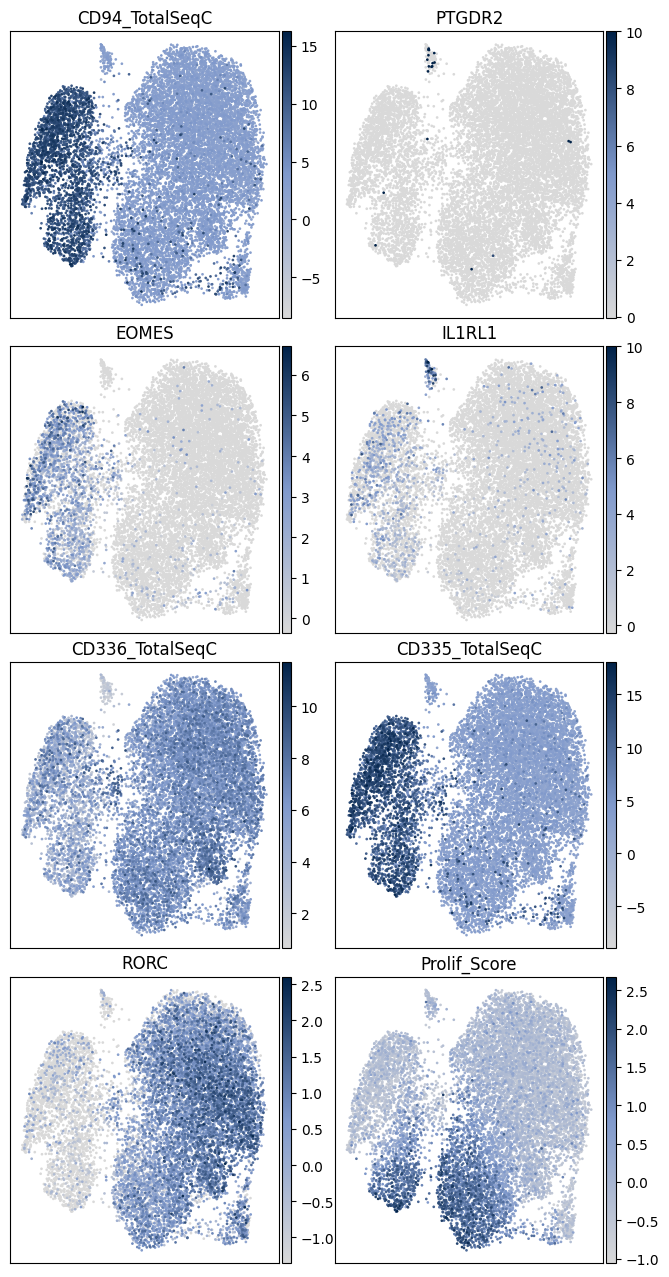

In [27]:
# Create a figure and axes to hold multiple plots
fig, axes = plt.subplots(4, 2, figsize=(8, 16), gridspec_kw={"wspace": 0.1, "hspace": 0.1})  # Adjust grid size based on number of plots

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each marker and corresponding subplot
for i, marker in enumerate(['CD94_TotalSeqC', 'PTGDR2', 'EOMES', 'IL1RL1', 'CD336_TotalSeqC', 'CD335_TotalSeqC', 'RORC', 'Prolif_Score']):
    sc.pl.umap(day_28_data_combined.mod['rna'], color=marker, ax=axes[i], show=False, color_map=cmap_custom, layer='scale_counts', size=15)
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('')  # Remove y-axis label
    #axes[i].set_title('')  # Remove title

# Adjust layout and display the figure
#plt.tight_layout()
plt.show()
#fig.savefig("figures/figure2b_8feats_plots.png", dpi=300, bbox_inches="tight")

#### Figure 2C

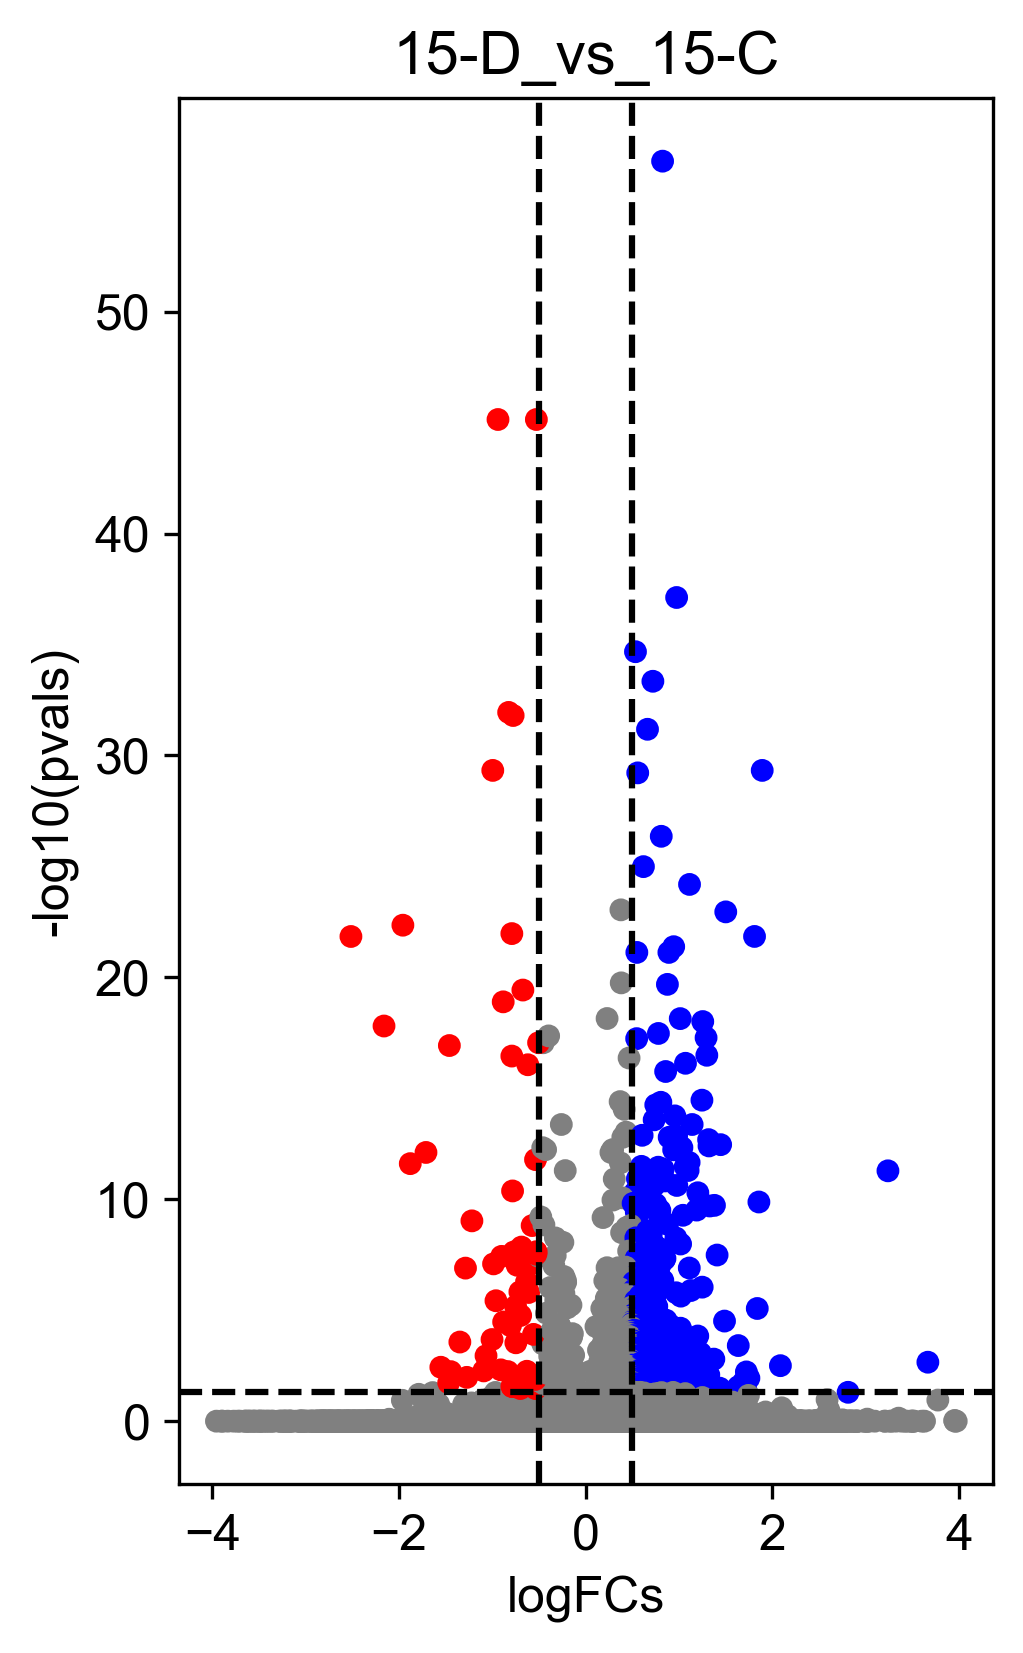

In [107]:
sc.tl.rank_genes_groups(
    D28_NK.mod['rna'], 
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    layer='log_counts',
    groupby='cell_condition',
    group=['NK_15-D'],
    reference='NK_15-C', 
    pts=True
)

# Extract DE results for contrast '15-C' vs '15-D'
de_df = sc.get.rank_genes_groups_df(
    D28_NK.mod['rna'], 
    group='NK_15-D',          # or '15-D' (reference group)
    key='rank_genes_groups'
)

# Filter the DataFrame to drop rows outside the range (-6, 6)
# The genes that had huge logfold chanes generally were not statistically significantly different
# Filtering them helps make the graph look easier to read and they are not very informative
#de_df = de_df[(de_df['logfoldchanges'] >= -5) & (de_df['logfoldchanges'] <= 5)]

# Now reconstruct the matrices using the FILTERED de_df
# It is crucial to rebuild both logFCs and pvals so they have the exact same genes (columns)
logFCs = pd.DataFrame(
    data=[de_df['logfoldchanges'].values], 
    index=['15-D_vs_15-C'], 
    columns=de_df['names']
)

pvals = pd.DataFrame(
    data=[de_df['pvals_adj'].values], 
    index=['15-D_vs_15-C'], 
    columns=de_df['names']
)

# 2. Generate the base plot from Decoupler
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='15-D_vs_15-C',
    top=0,
    sign_thr=0.05,
    lFCs_thr=0.5,
    lFCs_limit=4,
    figsize=(3.5, 6), # Slightly wider to accommodate labels on sides
    return_fig=False,
    color_pos='blue',
    color_neg='red',
    color_null='gray',
    save='figures/wilcoxon_D28_volcano.png',
    dpi=300
)

The code below is to help reference where specific genes are on the graph for downstream labeling

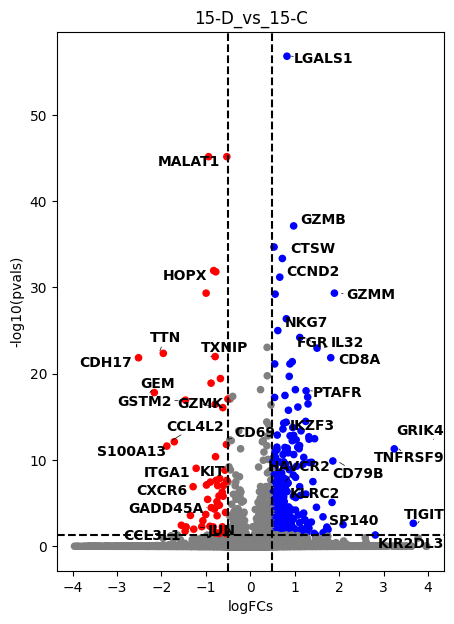

In [115]:
# ---------------------------
# 1. Define the specific genes you want to see
genes_to_label = [
    'GRIK4', 'TIGIT', 'TNFRSF9', 'KIR2DL3', 'GZMB', 'HAVCR2', 'LGALS1', 'GZMM', 'NKG7', 'IKZF3', 'CD79B', 'CD8A', 'SP140', 'IL32', 'PTAFR', 'FGR', 'KLRC2', 'CTSW', 'CCND2',
    'MALAT1', 'ITGA1', 'CXCR6', 'KIT', 'JUN', 'GZMK', 'HOPX', 'CDH17', 'GEM', 'CD69', 'TTN', 'S100A13', 'CCL4L2', 'GSTM2', 'CCL3L1', 'GADD45A', 'TXNIP'
]

# 2. Generate the base plot from Decoupler
fig = dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='15-D_vs_15-C',
    top=0,
    sign_thr=0.05,
    lFCs_thr=0.5,
    lFCs_limit=4,
    figsize=(5, 7), # Slightly wider to accommodate labels on sides
    return_fig=True,
    color_pos='blue',
    color_neg='red',
    color_null='gray'    
)

# 3. Get the axes
ax = fig.gca()

# 4. Loop through your genes and add labels
texts = []
for gene in genes_to_label:
    try:
        # Get coordinates
        x_val = logFCs.loc['15-D_vs_15-C', gene]
        p_val = pvals.loc['15-D_vs_15-C', gene]
        y_val = -np.log10(p_val)
        
        # --- THE FIX: Determine alignment based on side ---
        if x_val < 0:
            # Negative LogFC -> Put text on the LEFT
            align = 'right'
            nudge = -0.1 # Small offset to the left so it doesn't touch the dot
        else:
            # Positive LogFC -> Put text on the RIGHT
            align = 'left'
            nudge = 0.1  # Small offset to the right
            
        # Add text with specific Horizontal Alignment (ha)
        texts.append(ax.text(
            x_val + nudge, 
            y_val, 
            gene, 
            fontweight='bold', 
            fontsize=10, 
            ha=align,      # <--- This forces the direction
            va='center'
        ))        
        
    except KeyError:
        print(f"Warning: {gene} not found in the input dataframes.")

# 5. Automatically adjust text
# We allow movement in 'y' (up/down) freely, but try to restrict 'x' slightly
if 'adjust_text' in locals():
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='-', color='k', lw=0.5),
        # This helps keep them on their respective sides
        only_move={'points':'y', 'text':'xy'} 
    )

plt.show()

#### Figure 2D

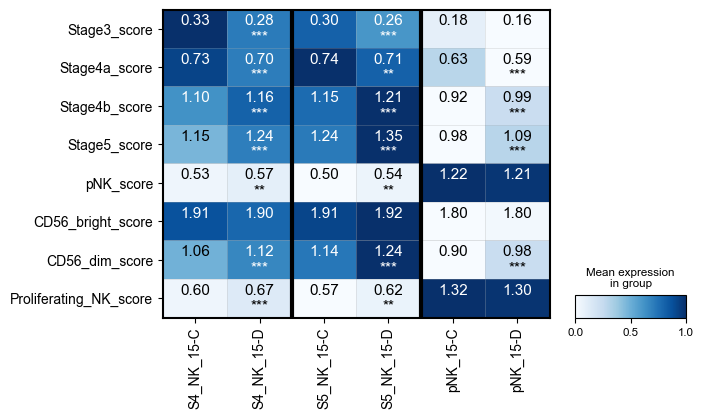

In [137]:
from statsmodels.stats.multitest import multipletests

# 1. Setup Data
scores = D28_NK['rna'].obs.columns.tolist()[40:48]
adata_subset = D28_NK['rna']
groupby_key = 'CD16_cell_condition'

categories_order = [
    'S4_NK_15-C', 'S4_NK_15-D', 
    'S5_NK_15-C', 'S5_NK_15-D', 
    'pNK_15-C',      'pNK_15-D'
]

pairs = {
    'S5_NK_15-D': 'S5_NK_15-C',
    'S4_NK_15-D': 'S4_NK_15-C',
    'pNK_15-D':      'pNK_15-C'
}

# 2. Plot
mp = sc.pl.matrixplot(adata_subset, groupby=groupby_key, var_names=scores,
                      categories_order=categories_order,
                      figsize=(6.75, 4), 
                      standard_scale='var', 
                      cmap="Blues",
                      swap_axes=True,
                      return_fig=True)

# 3. Get Real Data
obs_df = sc.get.obs_df(adata_subset, keys=scores + [groupby_key])
mean_df = obs_df.groupby(groupby_key, observed=False).mean()
mean_df = mean_df.reindex(categories_order)
scaled_df = (mean_df - mean_df.min()) / (mean_df.max() - mean_df.min())

# 4. Calculate Significance WITH CORRECTION
#    We define a list to store raw results before putting them in the DataFrame
raw_p_values = []
test_indices = [] # To remember which (group, gene) belongs to which p-value

for test_group, ref_group in pairs.items():
    if test_group in obs_df[groupby_key].values and ref_group in obs_df[groupby_key].values:
        test_data = obs_df[obs_df[groupby_key] == test_group]
        ref_data = obs_df[obs_df[groupby_key] == ref_group]
        
        for gene in scores:
            # Use Welch's t-test (equal_var=False) which is safer for biological data
            stat, p = stats.ttest_ind(test_data[gene], ref_data[gene], 
                                      nan_policy='omit', equal_var=False)
            
            # Store raw p-value and coordinate
            raw_p_values.append(p)
            test_indices.append((test_group, gene))

#    Apply Benjamini-Hochberg (FDR) correction
#    method='fdr_bh' is standard. Use 'bonferroni' if you want to be very strict.
reject, corrected_p_values, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

#    Map corrected values back to a DataFrame for plotting
p_values_df = pd.DataFrame(1.0, index=mean_df.index, columns=mean_df.columns)

for (group, gene), corrected_p in zip(test_indices, corrected_p_values):
    p_values_df.loc[group, gene] = corrected_p

# 5. Helper function for asterisks
def get_sig_string(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

# 6. Add Text
ax = mp.get_axes()['mainplot_ax']

for y_i, gene in enumerate(scores):
    for x_i, group in enumerate(mean_df.index):
        
        bg_val = scaled_df.loc[group, gene]
        if pd.isna(bg_val): bg_val = 0 
        text_color = 'white' if bg_val > 0.5 else 'black'
        
        real_val = mean_df.loc[group, gene]
        
        # Now retrieving the CORRECTED p-value
        p_val = p_values_df.loc[group, gene]
        sig_str = get_sig_string(p_val)
        
        display_str = f"{real_val:.2f}\n{sig_str}"
        
        ax.text(x_i + 0.5, y_i + 0.5, display_str,
                ha='center', va='center', color=text_color, fontsize=11)

# 7. Formatting
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.axvline(x=2, color='black', linewidth=3)
ax.axvline(x=4, color='black', linewidth=3)

plt.savefig('figures/NKDI_Scoring_D28.png', dpi=300, bbox_inches='tight')
plt.show()

#### Figure 2E

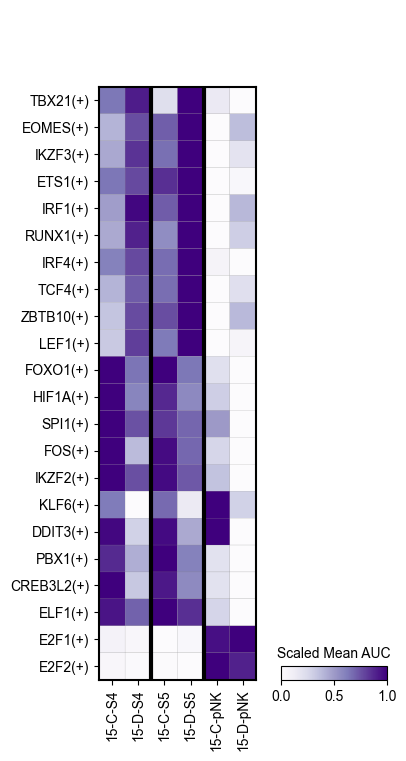

In [40]:
# 1. Get Activity Scores
scenic_auc = dc.get_acts(D28_NK['rna'], obsm_key='Pyscenic_AUC')

# 2. RENAME AND REORDER
# UPDATED MAP based on your previous error output
rename_map = {
    'S4_NK_15-C': '15-C-S4',
    'S4_NK_15-D': '15-D-S4',
    'S5_NK_15-C': '15-C-S5',
    'S5_NK_15-D': '15-D-S5',
    'pNK_15-C':   '15-C-pNK',
    'pNK_15-D':   '15-D-pNK'
}

# Apply map
scenic_auc.obs['final_grouping'] = scenic_auc.obs['CD16_cell_condition'].map(rename_map)

# Set categories safely
desired_order = ['15-C-S4', '15-D-S4', '15-C-S5', '15-D-S5', '15-C-pNK', '15-D-pNK']
scenic_auc.obs['final_grouping'] = scenic_auc.obs['final_grouping'].astype('category')
scenic_auc.obs['final_grouping'] = scenic_auc.obs['final_grouping'].cat.set_categories(desired_order)

regulons_raw = ['TBX21', 'EOMES', 'IKZF3', 'ETS1','IRF1', 'RUNX1', 'IRF4', 'TCF4', 'ZBTB10', 'LEF1',
                'FOXO1', 'HIF1A', 'SPI1', 'FOS', 'IKZF2', 'KLF6', 'DDIT3', 'PBX1', 'CREB3L2', 'ELF1', 'E2F1', 'E2F2']
regulons_to_plot = [r + '(+)' for r in regulons_raw]

# 4. PLOTTING
# Assign the MatrixPlot object to 'mp'
mp = sc.pl.matrixplot(
    scenic_auc,
    var_names=regulons_to_plot,
    standard_scale='var',
    groupby='final_grouping',
    colorbar_title='Scaled Mean AUC',
    cmap='Purples',
    swap_axes=True,
    dendrogram=False,
    return_fig=True,
    show=False
)

# FIX: Force Scanpy to build the figure so .ax_dict is created
mp.make_figure()

# NOW you can access the axes
ax = mp.ax_dict['mainplot_ax']

ymin, ymax = ax.get_ylim()
# Draw thick lines between groups
# x=1.5 is between the 2nd and 3rd column
# x=3.5 is between the 4th and 5th column
ax.vlines(x=[2, 4], ymin=ymin, ymax=ymax, colors='black', linewidth=3)

mp.fig.savefig('figures/Figure_2E_Regulons.png', dpi=300, bbox_inches='tight')
plt.show()

## Supplemental Figure 2

#### Figure S2A

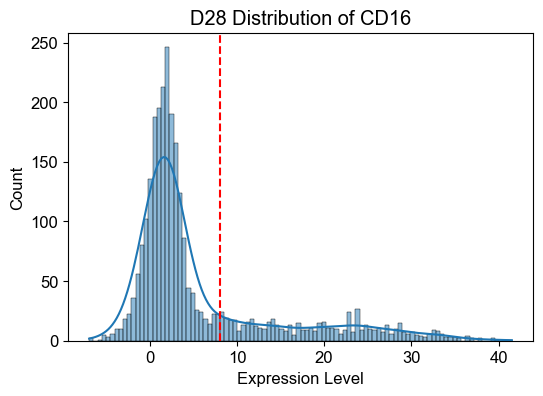

In [41]:
# Extract just the protein values
feature = 'CD16'
data_values = D28_NK['prot'][:, f'{feature}_TotalSeqC'].X.toarray().flatten()

# Plot histogram with a density curve
plt.figure(figsize=(6, 4))
sns.histplot(data_values, bins=100, kde=True)
plt.title(f'D28 Distribution of {feature}')
plt.xlabel('Expression Level')
plt.axvline(x=8, color='red', linestyle='--') # Example: Visualize where a cutoff of 8 lands
plt.savefig('figures/CD16_Histogram_D28.png', dpi=300)
plt.show()

#sc.pl.umap(D28_NK['prot'], color='CD16_TotalSeqC')

#### Figure S2B

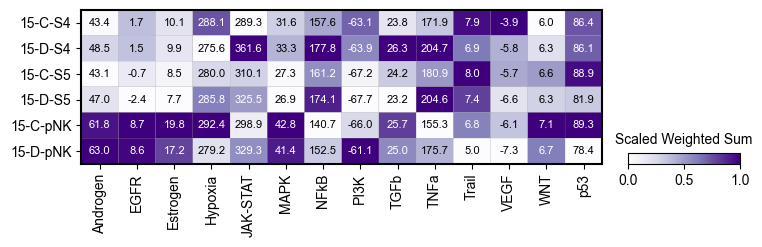

In [47]:
# Progeny scoring at day 28 subset by CD16 status
D28_prog = dc.get_acts(D28_NK['rna'], obsm_key='progeny_wsum')

rename_map = {
    'S4_NK_15-C': '15-C-S4',
    'S4_NK_15-D': '15-D-S4',
    'S5_NK_15-C': '15-C-S5',
    'S5_NK_15-D': '15-D-S5',
    'pNK_15-C':   '15-C-pNK',
    'pNK_15-D':   '15-D-pNK'
}

# Apply map
D28_prog.obs['final_grouping'] = D28_prog.obs['CD16_cell_condition'].map(rename_map)

# 1. PRE-CALCULATE RAW DATA
# We manually replicate the 'groupby' aggregation to get raw means
# This dataframe will be used ONLY for the text labels
raw_df = D28_prog[:, D28_prog.var_names].to_df()
raw_df['group'] = D28_prog.obs['final_grouping']
raw_means = raw_df.groupby('group', observed=False).mean()

# 2. CREATE THE PLOT (SCALED)
# We keep standard_scale='var' here so the colors look right
mp = sc.pl.matrixplot(D28_prog, 
                      groupby='final_grouping', 
                      cmap='Purples',
                      standard_scale='var', 
                      dendrogram=False, 
                      var_names=D28_prog.var_names, 
                      colorbar_title='Scaled Weighted Sum',
                      return_fig=True, 
                      figsize=(8.5,2),
                      show=False) 
mp.make_figure()

# 3. SETUP AXES & COORDS
ax = mp.ax_dict['mainplot_ax']
x_locs = ax.get_xticks()
y_locs = ax.get_yticks()
x_labels = [label.get_text() for label in ax.get_xticklabels()]
y_labels = [label.get_text() for label in ax.get_yticklabels()]

# 4. LOOP & ANNOTATE
for i, y_pos in enumerate(y_locs):
    row_name = y_labels[i]
    
    for j, x_pos in enumerate(x_locs):
        col_name = x_labels[j]
        
        try:
            # A. Get the RAW value for the Text
            raw_val = raw_means.loc[row_name, col_name]
            
            # B. Get the SCALED value for the Color Logic
            # We look up the value Scanpy is actually plotting to decide 
            # if the background is dark or light.
            scaled_val = mp.values_df.loc[row_name, col_name]
            
            # Determine text color based on background intensity
            # (Assuming Viridis/dark-to-light cmap: low values are dark, high are light)
            # You may need to flip this inequality if using a reverse cmap
            text_color = 'black' if scaled_val < 0.5 else 'white'
            
            # Print the RAW value
            ax.text(x_pos, y_pos, f"{raw_val:.1f}", 
                    ha='center', va='center', fontsize=8, color=text_color)
                    
        except KeyError:
            continue
plt.savefig('figures/Progeny_D28.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 3

#### Figure 3A

--- KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY ---
Comparison: 15-D vs 15-C
Mean (15-D): 0.1905
Mean (15-C): 0.1778
P-value: 6.82e-24
------------------------------
--- GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY ---
Comparison: 15-D vs 15-C
Mean (15-D): 0.5321
Mean (15-C): 0.5122
P-value: 1.15e-15
------------------------------
--- GOBP_NATURAL_KILLER_CELL_MEDIATED_IMMUNITY ---
Comparison: 15-D vs 15-C
Mean (15-D): 0.1861
Mean (15-C): 0.1689
P-value: 1.66e-33
------------------------------


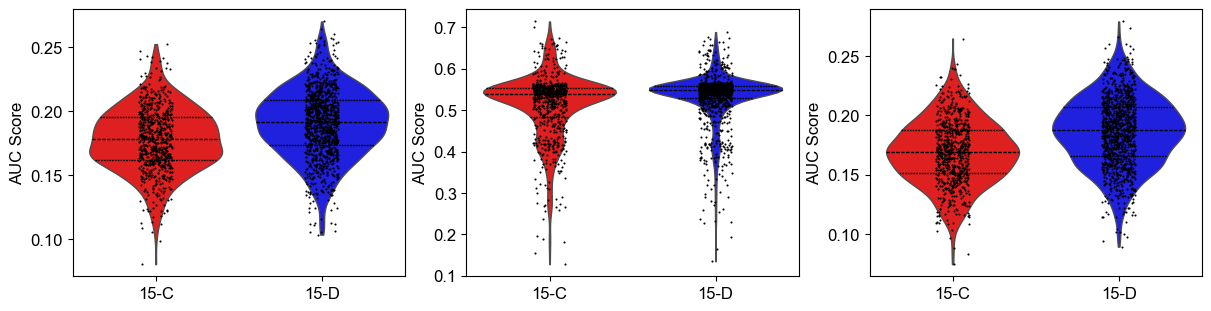

In [67]:
# 1. Prepare the data
pathways = [
    'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY', 
    'GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY', 
    'GOBP_NATURAL_KILLER_CELL_MEDIATED_IMMUNITY'
]

# Get the dataframe with conditions and scores
plot_df = sc.get.obs_df(D28_NK_auc, keys=['condition'] + pathways)

# 2. Define the Figure
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

# 3. Loop through pathways to Plot AND Calculate Stats
for i, key in enumerate(pathways):
    # --- A. Calculate Stats (Wilcoxon Rank-Sum) ---
    conditions = plot_df['condition'].unique()
    group1 = plot_df[plot_df['condition'] == conditions[0]][key]
    group2 = plot_df[plot_df['condition'] == conditions[1]][key]
    
    stat, p_val = stats.ranksums(group1, group2)
    
    # Calculate Means
    mean1 = group1.mean()
    mean2 = group2.mean()
    
    # Print stats to console
    print(f"--- {key} ---")
    print(f"Comparison: {conditions[0]} vs {conditions[1]}")
    print(f"Mean ({conditions[0]}): {mean1:.4f}")
    print(f"Mean ({conditions[1]}): {mean2:.4f}")
    print(f"P-value: {p_val:.2e}")
    print("-" * 30)

    # --- B. Plot Violin ---
    sns.violinplot(
        data=plot_df,
        x='condition',
        y=key,
        hue='condition',
        palette=['red', 'blue'],
        legend=False,
        inner='quart',
        inner_kws={'color':'black'},
        ax=axes[i],
        linewidth=1,
        cut=0                  # Optional: limits violin range to data range
    )
    
    # --- C. Add the Dots (Stripplot) ---
    sns.stripplot(
        data=plot_df,
        x='condition',
        y=key,
        color='black',         # Black dots stand out well
        size=1.5,                # Small size to prevent overcrowding
        #alpha=0.4,             # Transparency helps visualize density
        jitter=True,           # Spread them out horizontally
        ax=axes[i], 
    )
    
    # --- D. Formatting ---
    axes[i].set_xlabel('')
    axes[i].set_ylabel('AUC Score')
    
    # Add title with P-value
    # Adjust title size to fit long pathway names
    #short_title = key.split('_')[1] + "..." if len(key) > 30 else key
    #axes[i].set_title(f"{short_title}\n(p = {p_val:.1e})", fontsize=10)

plt.show()
fig.savefig("figures/D28_NK_Cyto_auc_with_dots.png", dpi=300, bbox_inches="tight")

## Supplemental Figure 3

#### Figure S3A

--- GZMB ---
Comparison: 15-C vs 15-D
Mean (15-C): 1.31 | Mean (15-D): 1.79
P-value: 1.29e-41
--- PRF1 ---
Comparison: 15-C vs 15-D
Mean (15-C): 1.43 | Mean (15-D): 1.46
P-value: 5.53e-01


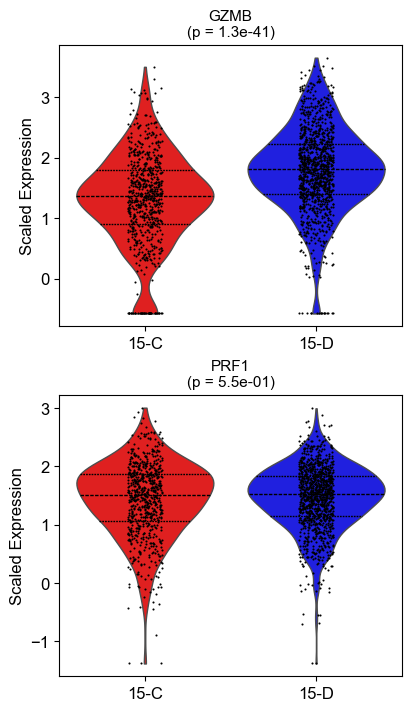

In [76]:
# ---------------------------------------------------------
# 1. Setup Data & Filter
# ---------------------------------------------------------
genes = ['GZMB', 'PRF1']

# Access the RNA modality
rna = D28_NK.mod['rna']

# Create a temporary subset that excludes pNK
# We assume the column is named 'celltype' based on your previous code
# If it's 'rna:cell_type', change 'celltype' to that.
subset_mask = ~rna.obs['celltype'].str.contains('pNK', case=False, na=False)
rna_subset = rna[subset_mask].copy()

# Extract data into a clean DataFrame (Handles layer automatically)
# This replaces the complex manual .X extraction
plot_df = sc.get.obs_df(
    rna_subset, 
    keys=['condition'] + genes, 
    layer='scale_counts'  # Uses your scaled counts
)

# ---------------------------------------------------------
# 2. Plot & Calculate Stats
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(4, 7), constrained_layout=True)

for i, gene in enumerate(genes):
    # --- A. Calculate Stats (Wilcoxon) ---
    conditions = plot_df['condition'].unique()
    # Ensure consistent order (e.g., 15-C then 15-D)
    conditions = sorted(conditions)
    
    group1 = plot_df[plot_df['condition'] == conditions[0]][gene]
    group2 = plot_df[plot_df['condition'] == conditions[1]][gene]
    
    stat, p_val = stats.ranksums(group1, group2)
    mean1, mean2 = group1.mean(), group2.mean()
    
    # Print to console for your records
    print(f"--- {gene} ---")
    print(f"Comparison: {conditions[0]} vs {conditions[1]}")
    print(f"Mean ({conditions[0]}): {mean1:.2f} | Mean ({conditions[1]}): {mean2:.2f}")
    print(f"P-value: {p_val:.2e}")

    # --- B. Violin Plot ---
    sns.violinplot(
        data=plot_df,
        x='condition',
        y=gene,
        hue='condition',
        palette=['red', 'blue'],
        legend=False,
        inner='quart',
        ax=axes[i],
        linewidth=1,
        cut=0, 
        inner_kws={'color':'black'}
    )
    
    # --- C. Add Dots ---
    sns.stripplot(
        data=plot_df,
        x='condition',
        y=gene,
        color='black',
        size=1.5,
        marker='o',        # Force circle
        linewidth=0,       # Remove outline (fixes '+' shape)
        jitter=True,
        ax=axes[i]
    )

    # --- D. Formatting ---
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Scaled Expression')
    axes[i].set_title(f"{gene}\n(p = {p_val:.1e})", fontsize=11)

# Save
fig.savefig("figures/D28_NK_GZMB_PRF1.png", dpi=300, bbox_inches="tight")
plt.show()

## Figure 5

#### Figure 5A

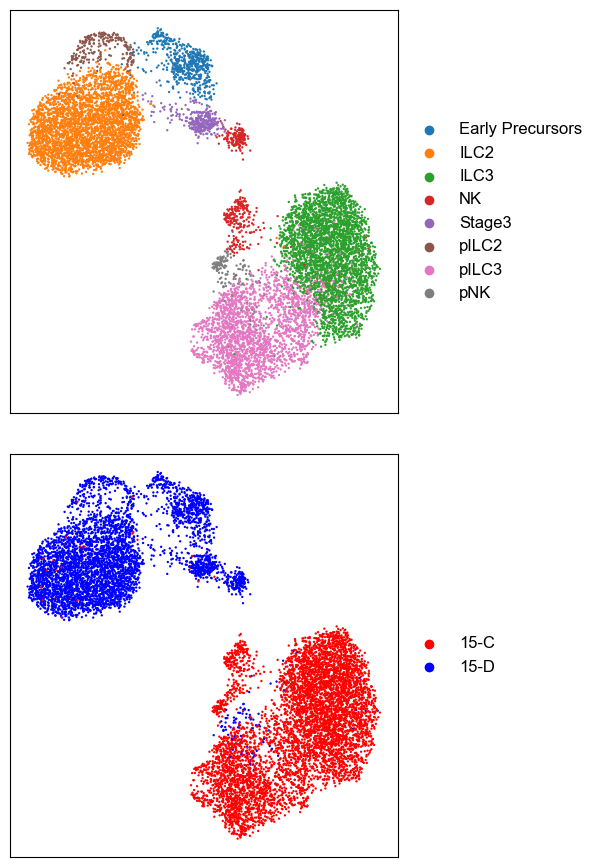

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 11), gridspec_kw={"hspace": 0.1})

ax1_dict = sc.pl.umap(
    day_14_data_combined.mod['rna'], color='celltype', ax=ax1, show=False, legend_fontsize=12, title=''
)
ax1.set_xlabel('')  # Remove X-axis label
ax1.set_ylabel('')  # Remove Y-axis label

ax2_dict = sc.pl.umap(
    day_14_data_combined.mod['rna'], color='condition', ax=ax2, show=False, legend_fontsize=12, title='', palette=['red', 'blue']
)
ax2.set_xlabel('')  # Remove X-axis label
ax2.set_ylabel('')  # Remove Y-axis label

# Save the figure
fig.savefig("figures/d14_umaps_plot.png", dpi=300, bbox_inches="tight")

#### Figure 5B

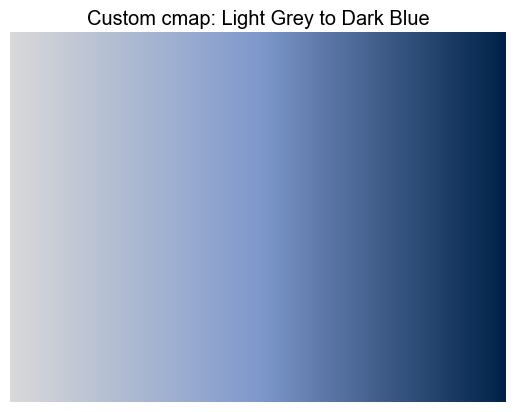

In [81]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = [(0.85, 0.85, 0.85), (0.5, 0.6, 0.8), (0.0, 0.13, 0.28)]

# Create the custom colormap
cmap_custom = LinearSegmentedColormap.from_list("custom_blue", colors)

# Optional: visualize it
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, aspect='auto', cmap=cmap_custom)
plt.axis('off')
plt.title("Custom cmap: Light Grey to Dark Blue")
plt.show()

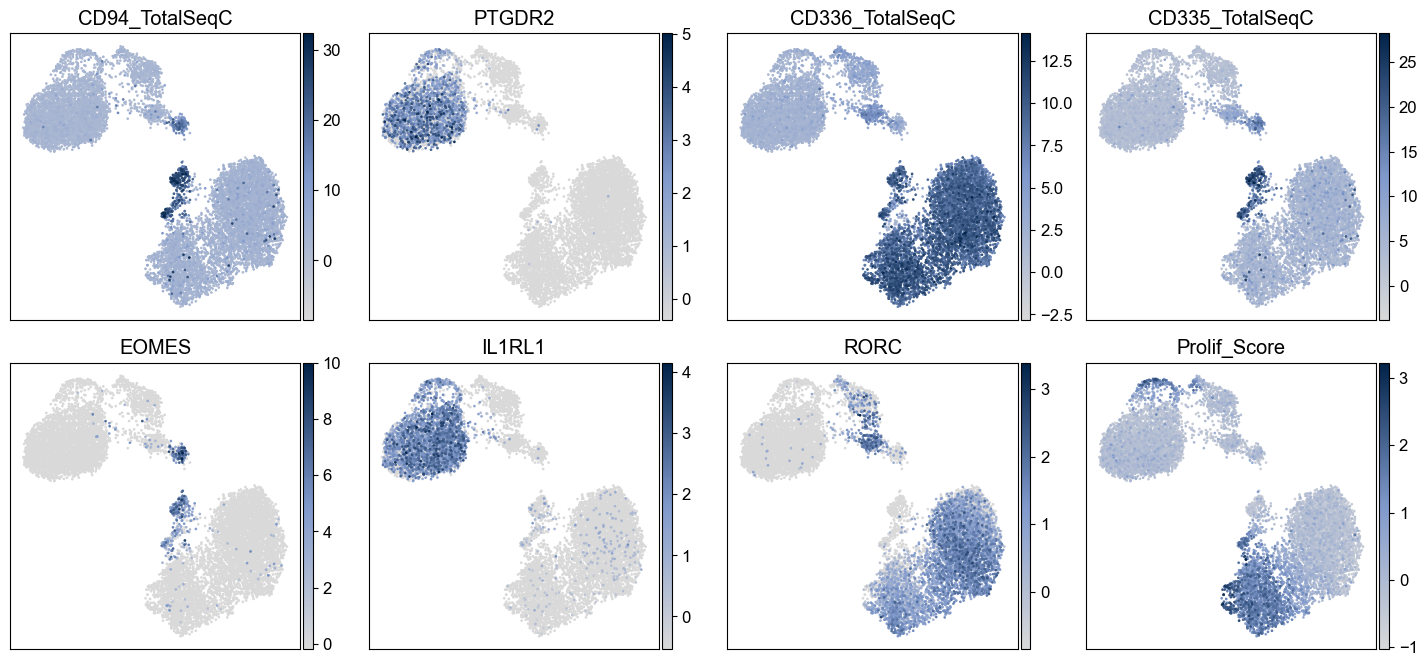

In [98]:
# Create a figure and axes to hold multiple plots
fig, axes = plt.subplots(2, 4, figsize=(18, 8), gridspec_kw={"wspace": 0.125, "hspace": 0.15})  # Adjust grid size based on number of plots

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each marker and corresponding subplot
for i, marker in enumerate(['CD94_TotalSeqC', 'PTGDR2', 'CD336_TotalSeqC', 'CD335_TotalSeqC', 'EOMES', 'IL1RL1', 'RORC', 'Prolif_Score']):
    sc.pl.umap(day_14_data_combined.mod['rna'], color=marker, ax=axes[i], show=False, color_map=cmap_custom, layer='scale_counts', size=15)
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('')  # Remove y-axis label
    #axes[i].set_title('')  # Remove title

# Adjust layout and display the figure
#plt.tight_layout()
plt.show()
#fig.savefig("figures/figure5B_8feats_plots.png", dpi=300, bbox_inches="tight")

#### Figure 5C

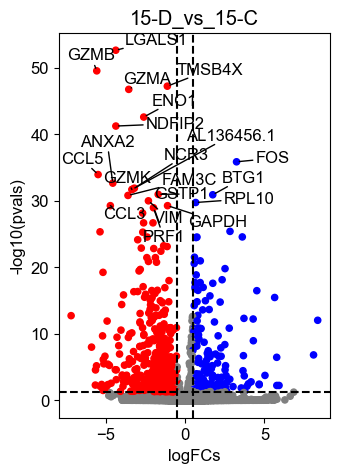

In [128]:
sc.tl.rank_genes_groups(
    D14_NK.mod['rna'], 
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    layer='log_counts',
    groupby='cell_condition',
    group=['NK_15-D'],
    reference='NK_15-C', 
    pts=True
)

# Extract DE results for contrast '15-C' vs '15-D'
de_df = sc.get.rank_genes_groups_df(
    D14_NK.mod['rna'], 
    group='NK_15-D',          # or '15-D' (reference group)
    key='rank_genes_groups'
)

# Filter the DataFrame to drop rows outside the range (-6, 6)
# The genes that had huge logfold chanes generally were not statistically significantly different
# Filtering them helps make the graph look easier to read and they are not very informative
#de_df = de_df[(de_df['logfoldchanges'] >= -5) & (de_df['logfoldchanges'] <= 5)]

# Now reconstruct the matrices using the FILTERED de_df
# It is crucial to rebuild both logFCs and pvals so they have the exact same genes (columns)
logFCs = pd.DataFrame(
    data=[de_df['logfoldchanges'].values], 
    index=['15-D_vs_15-C'], 
    columns=de_df['names']
)

pvals = pd.DataFrame(
    data=[de_df['pvals_adj'].values], 
    index=['15-D_vs_15-C'], 
    columns=de_df['names']
)

# 2. Generate the base plot from Decoupler
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='15-D_vs_15-C',
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5,
    lFCs_limit=10,
    figsize=(3.5, 5), # Slightly wider to accommodate labels on sides
    return_fig=False,
    color_pos='blue',
    color_neg='red',
    color_null='gray',
    #save='figures/wilcoxon_D14_volcano.png',
    #dpi=300
)

The code below is to help reference where specific genes are on the graph for downstream labeling

20 [0.62435924 0.04374869]
22 [0.84038597 0.0867518 ]


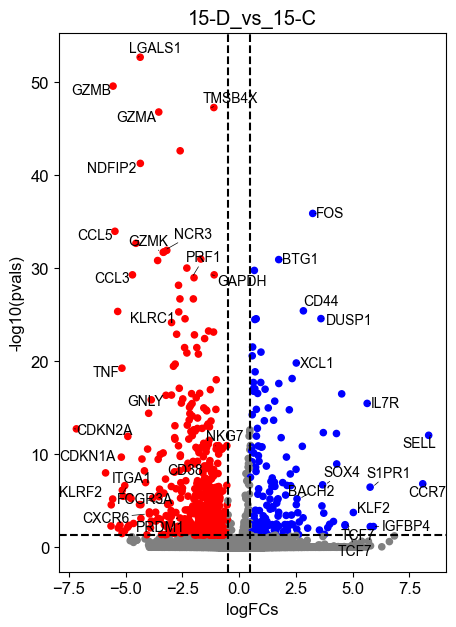

In [126]:
# ---------------------------
# 1. Define the specific genes you want to see
genes_to_label = [
    'GZMB', 'LGALS1', 'TMSB4X', 'NDFIP2', 'CCL5', 'GZMA', 'GZMK', 'NCR3', 'KLRC1', 'PRF1', 'CDKN2A', 'CDKN1A', 'KLRF2',
    'FOS', 'CD44', 'DUSP1', 'BTG1', 'GAPDH', 'IL7R', 'CCR7', 'TCF7', 'SELL', 'TCF7', 'BACH2', 'KLF2', 'S1PR1', 'SOX4', 'IGFBP4',
    'GNLY', 'NKG7', 'FCGR3A', 'CD38', 'PRDM1', 'ITGA1', 'CXCR6', 'CCL3', 'TNF', 'XCL1'
]

# 2. Generate the base plot from Decoupler
fig = dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='15-D_vs_15-C',
    top=0,
    sign_thr=0.05,
    lFCs_thr=0.5,
    lFCs_limit=10,
    figsize=(5, 7), # Slightly wider to accommodate labels on sides
    return_fig=True,
    color_pos='blue',
    color_neg='red',
    color_null='gray'    
)

# 3. Get the axes
ax = fig.gca()

# 4. Loop through your genes and add labels
texts = []
for gene in genes_to_label:
    try:
        # Get coordinates
        x_val = logFCs.loc['15-D_vs_15-C', gene]
        p_val = pvals.loc['15-D_vs_15-C', gene]
        y_val = -np.log10(p_val)
        
        # --- THE FIX: Determine alignment based on side ---
        if x_val < 0:
            # Negative LogFC -> Put text on the LEFT
            align = 'right'
            nudge = -0.1 # Small offset to the left so it doesn't touch the dot
        else:
            # Positive LogFC -> Put text on the RIGHT
            align = 'left'
            nudge = 0.1  # Small offset to the right
            
        # Add text with specific Horizontal Alignment (ha)
        texts.append(ax.text(
            x_val + nudge, 
            y_val, 
            gene, 
            fontweight='bold', 
            fontsize=10, 
            ha=align,      # <--- This forces the direction
            va='center'
        ))        
        
    except KeyError:
        print(f"Warning: {gene} not found in the input dataframes.")

# 5. Automatically adjust text
# We allow movement in 'y' (up/down) freely, but try to restrict 'x' slightly
if 'adjust_text' in locals():
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='-', color='k', lw=0.5),
        # This helps keep them on their respective sides
        only_move={'points':'y', 'text':'xy'} 
    )

plt.show()

#### Figure 5D

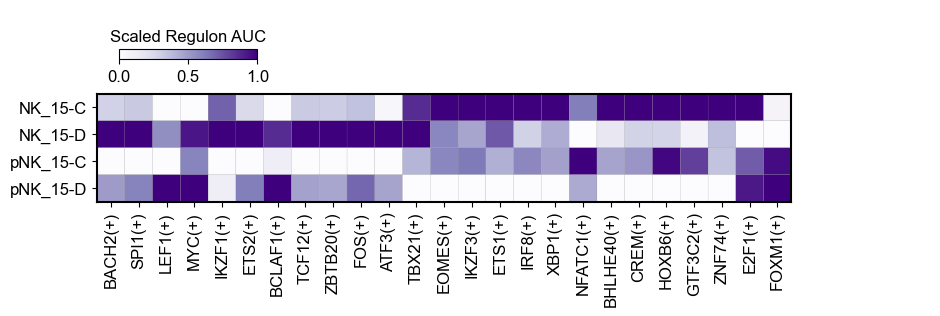

In [149]:
d14_pysc = dc.get_acts(D14_NK['rna'], obsm_key='Pyscenic_AUC')
# 22 Regulons for Day 14 Volcano Plot (15-D vs 15-C)
# 15-D = Physiologic Immaturity / Progenitor-like (Right Side)
# 15-C = Hyper-Mature / Effector Stress (Left Side)

regulons = [
    'BACH2(+)',   # The "Brake" on differentiation (Top Hit)
    'SPI1(+)',    # PU.1 (Progenitor marker)
    'LEF1(+)',    # Wnt/Stemness
    'MYC(+)',     # Proliferation/Metabolism and KIR expression
    'IKZF1(+)',   # Ikaros (Early lymphoid)
    'ETS2(+)',    # Survival/Maintenance
    'BCLAF1(+)',  # Anti-apoptotic/Survival
    'TCF12(+)',   # E-protein (HEB)
    'ZBTB20(+)',  # Lineage stability
    'FOS(+)',     # Early activation/Cycling
    'ATF3(+)',    # Adaptive stress response
    'TBX21(+)',   # Terminal Maturation Driver
    'EOMES(+)',   # Drives NK Cells Toward Cytotoxicity and Maturation
    'IKZF3(+)',   # Aiolos (Late-stage partner to Ikaros)
    'ETS1(+)',    # Effector fitness
    'IRF8(+)',    # Functional maturation
    'XBP1(+)',    # UPR / Secretory Stress (Key finding!)
    'NFATC1(+)',  # Strong Activation/Exhaustion
    'BHLHE40(+)', # Cytokine production (IFNg)
    'CREM(+)',    # Repressor/cAMP response
    'HOXB6(+)',   # Top statistical hit for this group
    'GTF3C2(+)',  # High metabolic demand (tRNA synthesis)
    'ZNF74(+)',   # Consistent marker
    'E2F1(+)',    # G1/S Transition
    'FOXM1(+)'    # G2/M Transition
]
dp = sc.pl.matrixplot(d14_pysc, groupby='cell_condition', var_names=regulons, dendrogram=False, swap_axes=False, cmap='Purples', colorbar_title='Mean Regulon AUC', 
              show = False, standard_scale='var'
              #save='Figure5D_Regulons.png'
                  )

# 2. Get the figure and all axes objects
fig = dp['mainplot_ax'].get_figure()
ax_main = dp['mainplot_ax']
ax_color_legend = dp['color_legend_ax']

# 3. Apply font styling
# Conventionally, gene names (x-axis) are italicized.
for label in ax_main.get_xticklabels():
    # Check if the label's text contains "proliferating "
    if 'Proliferating ' in label.get_text():
        # If it does, set the label text to "p"
        label.set_text('p')
    label.set_fontsize(12)
    label.set_fontweight('bold')

for label in ax_main.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontweight('bold')

# 4. Reposition the plot and legends
# First, get the original position of the main plot
orig_pos = ax_main.get_position()

# Shrink the main plot's height to make space at the top
#ax_main.set_position([orig_pos.x0, orig_pos.y0, orig_pos.width *1.5, orig_pos.height * 0.87])

# --- LEGEND SIZE ADJUSTMENT ---
# I've reduced the width from 0.45 to 0.4 and the height from 0.05 to 0.03
ax_color_legend.set_position([orig_pos.x0 + 0.02, 0.68, orig_pos.width * 0.2, 0.04])

# Modify the font sizes for the color legend
ax_color_legend.set_title('Scaled Regulon AUC', fontsize=12, font='Arial')
ax_color_legend.tick_params(axis='x', labelsize=12)

# Save the plot
#plt.savefig('figures/d14_regulons_matrixplot_horizontal.png', dpi=300,bbox_inches='tight')
# Show the final plot
plt.show()
#sc.pl.rank_genes_groups_dotplot(d14_pysc, groupby='cell_condition', n_genes=10, dendrogram=False, swap_axes=True)

#### Figure 5E

In [150]:
# 1. Extract PROGENy activities (usually in .obsm['progeny_mlm_estimate'] or similar depending on how you ran it)
# Let's assume you used MLM for PROGENy
progeny_acts = dc.get_acts(D14_NK['rna'], obsm_key='progeny_wsum') # Replace with actual PROGENy key if different

# 2. Extract your specific mTOR AUCell scores
# Let's assume you saved AUCell results to .obsm['aucell_estimate']
aucell_acts = dc.get_acts(D14_NK['rna'], obsm_key='msigdb_aucell')

# 3. Select the specific features you want to combine
# PROGENy broadly relevant paths
progeny_of_interest = ['PI3K', 'JAK-STAT', 'MAPK', 'EGFR', 'TNFa']
prog_subset = progeny_acts[:, progeny_of_interest].copy()

# Your highly specific mTOR genesets from AUCell
msig_of_interest = ['HALLMARK_MTORC1_SIGNALING', 'KEGG_MTOR_SIGNALING_PATHWAY',
                    'HALLMARK_IL2_STAT5_SIGNALING', 'KEGG_JAK_STAT_SIGNALING_PATHWAY',
                    'BIOCARTA_AKT_PATHWAY', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING',
                    'KEGG_MAPK_SIGNALING_PATHWAY', 'BIOCARTA_ERK_PATHWAY']
mTOR_subset = aucell_acts[:, msig_of_interest].copy()

# 4. Combine them into a new 'fake' AnnData object for easy plotting
# We concatenate the variables (pathways) along the columns
combined_acts = sc.AnnData(
    X = pd.concat([progeny_acts.to_df(), mTOR_subset.to_df()], axis=1),
    obs = D14_NK['rna'].obs.copy() # Keep your metadata (Condition, Day, etc.)
)

# Optional: Standardize scores if they are on vastly different scales so the heatmap looks balanced
# combined_acts.X = (combined_acts.X - combined_acts.X.mean(axis=0)) / combined_acts.X.std(axis=0)

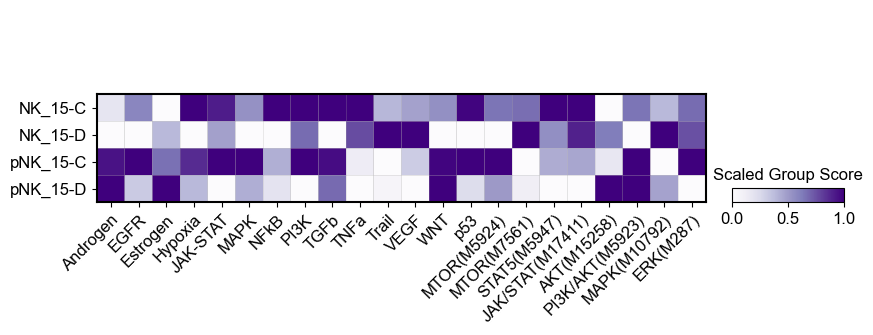

In [152]:
# 1. Define your mapping dictionary
Pathway_Names_Changes = {
    'HALLMARK_MTORC1_SIGNALING':'MTOR(M5924)', # Note: MSigDB is usually all caps, double-check your actual var_names case if this fails
    'KEGG_MTOR_SIGNALING_PATHWAY':'MTOR(M7561)',
    'HALLMARK_IL2_STAT5_SIGNALING':'STAT5(M5947)',
    'KEGG_JAK_STAT_SIGNALING_PATHWAY':'JAK/STAT(M17411)',
    'BIOCARTA_AKT_PATHWAY':'AKT(M15258)',
    'HALLMARK_PI3K_AKT_MTOR_SIGNALING':'PI3K/AKT(M5923)',
    'KEGG_MAPK_SIGNALING_PATHWAY':'MAPK(M10792)',
    'BIOCARTA_ERK_PATHWAY':'ERK(M287)'
}

# 2. Apply the renaming
# This list comprehension goes through current names and replaces them if they are in your dict,
# otherwise it keeps the original name.
combined_acts.var_names = [Pathway_Names_Changes.get(name, name) for name in combined_acts.var_names]

# 1. Set global font properties to Arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 3. Now plot as usual, and the new names will appear automatically
p1 = sc.pl.matrixplot(
    combined_acts,
    var_names=combined_acts.var_names, # Now uses updated names
    groupby='cell_condition',
    cmap='Purples',
    standard_scale='var', 
    return_fig=False, 
    show=False
)

fig = p1['mainplot_ax'].get_figure()
ax_main = p1['mainplot_ax']
ax_color_legend = p1['color_legend_ax']

for label in ax_main.get_xticklabels():
    label.set_fontsize(12)
    label.set_rotation(45)
    label.set_ha('right')
    label.set_rotation_mode('anchor')
for label in ax_main.get_yticklabels():
    label.set_fontsize(12)
ax_color_legend.set_title('Scaled Group Score', fontsize=12)
ax_color_legend.tick_params(axis='x', labelsize=12)

plt.savefig('figures/d14_progeny_msig_matrixplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Supplemental Figure 5

#### Figure S5A

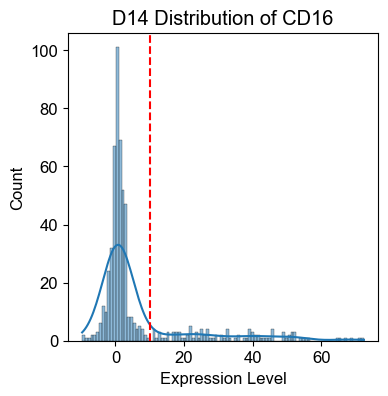

In [164]:
# Extract just the protein values
feature = 'CD16'
data_values = D14_NK['prot'][:, f'{feature}_TotalSeqC'].X.toarray().flatten()

# Plot histogram with a density curve
plt.figure(figsize=(4, 4))
sns.histplot(data_values, bins=100, kde=True)
plt.title(f'D14 Distribution of {feature}')
plt.xlabel('Expression Level')
plt.axvline(x=10, color='red', linestyle='--') # Example: Visualize where a cutoff of 10 lands
plt.savefig('figures/CD16_Histogram_D14.png', dpi=300, bbox_inches='tight')
plt.show()

#sc.pl.umap(D28_NK['prot'], color='CD16_TotalSeqC')

#### Figure S5B

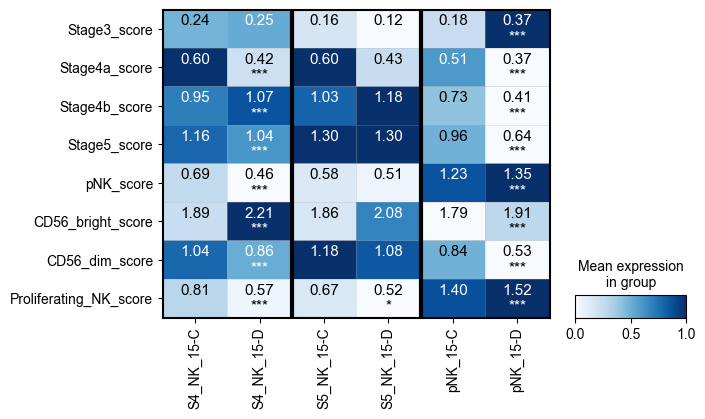

In [160]:
# 1. Setup Data
scores = D14_NK['rna'].obs.columns.tolist()[40:48]
adata_subset = D14_NK['rna']
groupby_key = 'CD16_cell_condition'

categories_order = [
    'S4_NK_15-C', 'S4_NK_15-D', 
    'S5_NK_15-C', 'S5_NK_15-D', 
    'pNK_15-C',      'pNK_15-D'
]

pairs = {
    'S5_NK_15-D': 'S5_NK_15-C',
    'S4_NK_15-D': 'S4_NK_15-C',
    'pNK_15-D': 'pNK_15-C'
}

# 2. Plot
mp = sc.pl.matrixplot(adata_subset, groupby=groupby_key, var_names=scores,
                      categories_order=categories_order,
                      figsize=(6.75, 4), 
                      standard_scale='var', 
                      cmap="Blues",
                      swap_axes=True,
                      return_fig=True)

# 3. Get Real Data
obs_df = sc.get.obs_df(adata_subset, keys=scores + [groupby_key])
mean_df = obs_df.groupby(groupby_key, observed=False).mean()
mean_df = mean_df.reindex(categories_order)
scaled_df = (mean_df - mean_df.min()) / (mean_df.max() - mean_df.min())

# 4. Calculate Significance WITH CORRECTION
#    We define a list to store raw results before putting them in the DataFrame
raw_p_values = []
test_indices = [] # To remember which (group, gene) belongs to which p-value

for test_group, ref_group in pairs.items():
    if test_group in obs_df[groupby_key].values and ref_group in obs_df[groupby_key].values:
        test_data = obs_df[obs_df[groupby_key] == test_group]
        ref_data = obs_df[obs_df[groupby_key] == ref_group]
        
        for gene in scores:
            # Use Welch's t-test (equal_var=False) which is safer for biological data
            stat, p = stats.ttest_ind(test_data[gene], ref_data[gene], 
                                      nan_policy='omit', equal_var=False)
            
            # Store raw p-value and coordinate
            raw_p_values.append(p)
            test_indices.append((test_group, gene))

#    Apply Benjamini-Hochberg (FDR) correction
#    method='fdr_bh' is standard. Use 'bonferroni' if you want to be very strict.
reject, corrected_p_values, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

#    Map corrected values back to a DataFrame for plotting
p_values_df = pd.DataFrame(1.0, index=mean_df.index, columns=mean_df.columns)

for (group, gene), corrected_p in zip(test_indices, corrected_p_values):
    p_values_df.loc[group, gene] = corrected_p

# 5. Helper function for asterisks
def get_sig_string(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

# 6. Add Text
ax = mp.get_axes()['mainplot_ax']

for y_i, gene in enumerate(scores):
    for x_i, group in enumerate(mean_df.index):
        
        bg_val = scaled_df.loc[group, gene]
        if pd.isna(bg_val): bg_val = 0 
        text_color = 'white' if bg_val > 0.5 else 'black'
        
        real_val = mean_df.loc[group, gene]
        
        # Now retrieving the CORRECTED p-value
        p_val = p_values_df.loc[group, gene]
        sig_str = get_sig_string(p_val)
        
        display_str = f"{real_val:.2f}\n{sig_str}"
        
        ax.text(x_i + 0.5, y_i + 0.5, display_str,
                ha='center', va='center', color=text_color, fontsize=11)

# 7. Formatting
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.axvline(x=2, color='black', linewidth=3)
ax.axvline(x=4, color='black', linewidth=3)

plt.savefig('figures/d14_NKDI_modules.png', dpi=300, bbox_inches='tight')
plt.show()
#print(D14_NK['rna'].obs['CD16_cell_condition'].value_counts())
#print(p_values_df)

## Figure 7